In [1]:
import pandas as pd
import numpy as np

from lguhome.preprocessor import CustomizedKkma
from lguhome.preprocessor import KkmaTokenizer
from lguhome.preprocessor import post_processor_AN_NNG

from lguhome.preprocessor import post_processor_replace
from lguhome.preprocessor import post_processor_AI_NNG

from lguhome.preprocessor import load_dictionary
from lguhome.preprocessor import fake_Kkma


from konlpy.tag import Kkma

import os
import csv

import umap
import umap.plot

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram

import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import LdaModel
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import platform

%matplotlib inline


데이터 로딩 및 tokenizer 준비

In [2]:
work_folder = "C:\\Work\\Customer Exprience\\customerexp\\data\\googleplay\\target"

is_mac = False
if (platform.platform()[:5]=="macOS"):
    is_mac = True
    work_folder = "/Users/dongseokbaik/Documents/GitHub/customerexp/data/googleplay/target"

source_file = "[OTT][넷플릭스]_2209162306"
source_file_format = work_folder + os.sep + "{}_"+source_file + ".csv" #[OTT][넷플릭스]_2209162306.csv"
#target_file_format = work_folder + os.sep + "{}_"+source_file + ".csv" #[OTT][넷플릭스]_2209162306.csv"

# new file format
target_file_format_new = work_folder + os.sep + "{}{}_"+source_file+"{}"
dict_file_format   = work_folder + os.sep + "{}.csv"

stop_words = ['며칠/NNG','자체/NNG','아/VV','들이/VV','다그/VV','어/VV','그/VV','저/VV','드/VV','느/VV','시/VV',"블/VV","결하/VV","가요/NNG","지가/NNG","어제/NNG","지금/NNG","하세/NNG","있음/NNG"]
pass_words = ['앱',"돈","안","탭", "별", "잘", "왜", "안", "못"]
pass_tags = ['NNG','MAG','VV','VX',"VA","VXA","VXV","XSV"]

post_process_typo = load_dictionary(dict_file_format.format("typo_netflix"))
post_process_dict_data = load_dictionary(dict_file_format.format("dict_netflix"))
post_process_pos_data = load_dictionary(dict_file_format.format("pos_netflix"))

post_process_dict = {  key_pos:post_processor_replace(replaced_word=post_process_dict_data[key_pos]) for key_pos in post_process_dict_data  }
post_process_dict.update({'안/NNG':post_processor_AN_NNG()})
post_process_dict.update({'아이/NNG':post_processor_AI_NNG()})

post_processor_pos = [ (key_pos,post_process_pos_data[key_pos] ) for key_pos in post_process_pos_data  ]
analyzer = None

def tokenizer(doc):    
    result = analyzer.tokenizer(doc)
    return result

### 0. Data load

df_review_source = pd.read_csv(source_file_format.format("P4_1"))

if is_mac:
    analyzer = CustomizedKkma(fake_Kkma(source_file_format.format("P4_2"), df_review_source), post_process_dict, post_processor_pos,stop_words,pass_words, pass_tags, join = False, filtering = True)
else:
    analyzer = CustomizedKkma(Kkma(), post_process_dict, post_processor_pos,stop_words,pass_words, pass_tags, join = False, filtering = True)



차원 축소

DT:노트7FE에서 잘 봤는데 갑자기 오늘 기기에 호환되지 않습니다 라고 문구가 뜨면서 아무것도 안되네요. 제거했다가 재설치하려고하니 설치도 안되네요. 방법이 없는건가요?
진짜/NNG|자막/NNG|뒤/NNG|검정색/NNG|화/XSN|이/VCP|면/ECE|없애/VV|줘요/UN|정말/MAG|너무/MAG|불편/NNG|하/XSV|어요/EFN|이것/NP|이/JKS|뭔/MDT|가요/NNG|하나같이/MAG|다/MAG|업데이트/NNG|하/VV|다/MAG|이상/NNG|하/XSV|어요/EFN|짘/UN|짜/VV|아/ECS|./SF
Step1 ['진짜/NNG', '자막/NNG', '뒤/NNG', '검정색/NNG', '화/XSN', '이/VCP', '면/ECE', '없애/VV', '줘요/UN', '정말/MAG', '너무/MAG', '불편/NNG', '하/XSV', '어요/EFN', '이것/NP', '이/JKS', '뭔/MDT', '가요/NNG', '하나같이/MAG', '다/MAG', '업데이트/NNG', '하/VV', '다/MAG', '이상/NNG', '하/XSV', '어요/EFN', '짘/UN', '짜/VV', '아/ECS', './SF']
tokenize
Step2 진짜/NNG|자막/NNG|뒤/NNG|검정색/NNG|화면/NNG|없애/VV|줘요/UN|정말/MAG|너무/MAG|불편/NNG|하/XSV|어요/EFN|이것/NP|이/JKS|뭔/MDT|가요/NNG|하나같이/MAG|다/MAG|업데이트/NNG|하/VV|다/MAG|이상/NNG|하/XSV|어요/EFN|짘/UN|짜/VV|아/ECS|./SF
['진짜', '자막', '검정색', '화면', '없애', '정말', '너무', '불편', '하', '하나같이', '다', '업데이트', '하', '다', '이상', '하', '짜']
-----
갤럭시폴드/NNG|4/NR|에서/JKM|한국/NNG|드라마/NNG|한글/NNG|자막/NNG|끄/VV|기/ETN|없/VA|어서/ECD|강제/NNG|로/JKM|자막/NNG|보/VV|아야/ECD|되/VV|ㅁ/ETN

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

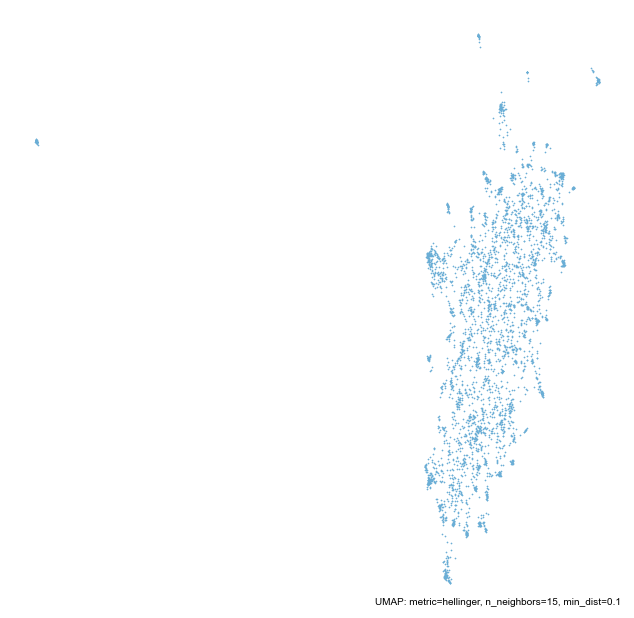

In [3]:

 ### 1. text를 Vector(수치화)로 변환 : TF-IDF 
model = TfidfVectorizer(tokenizer=tokenizer, ngram_range=(1,2) ,max_df=0.8, min_df=10)
print(f"DT:{df_review_source.iloc[3]['Review']}")
review_tfidf = model.fit_transform(df_review_source.Review)

### 2. 2차원으로 차원 축소 :  UMAP 알고리즘
review_umap = umap.UMAP(metric='hellinger').fit(review_tfidf)
df_review_umap = pd.DataFrame(review_umap.embedding_, columns=['PC1','PC2'])

plt.style.use('seaborn')
sns.set_palette("hls")

umap.plot.points(review_umap)

계층적 클러스터링

generating dendrogram...: 'single'
generating dendrogram...: 'complete'
generating dendrogram...: 'average'
generating dendrogram...: 'centroid'
generating dendrogram...: 'ward'


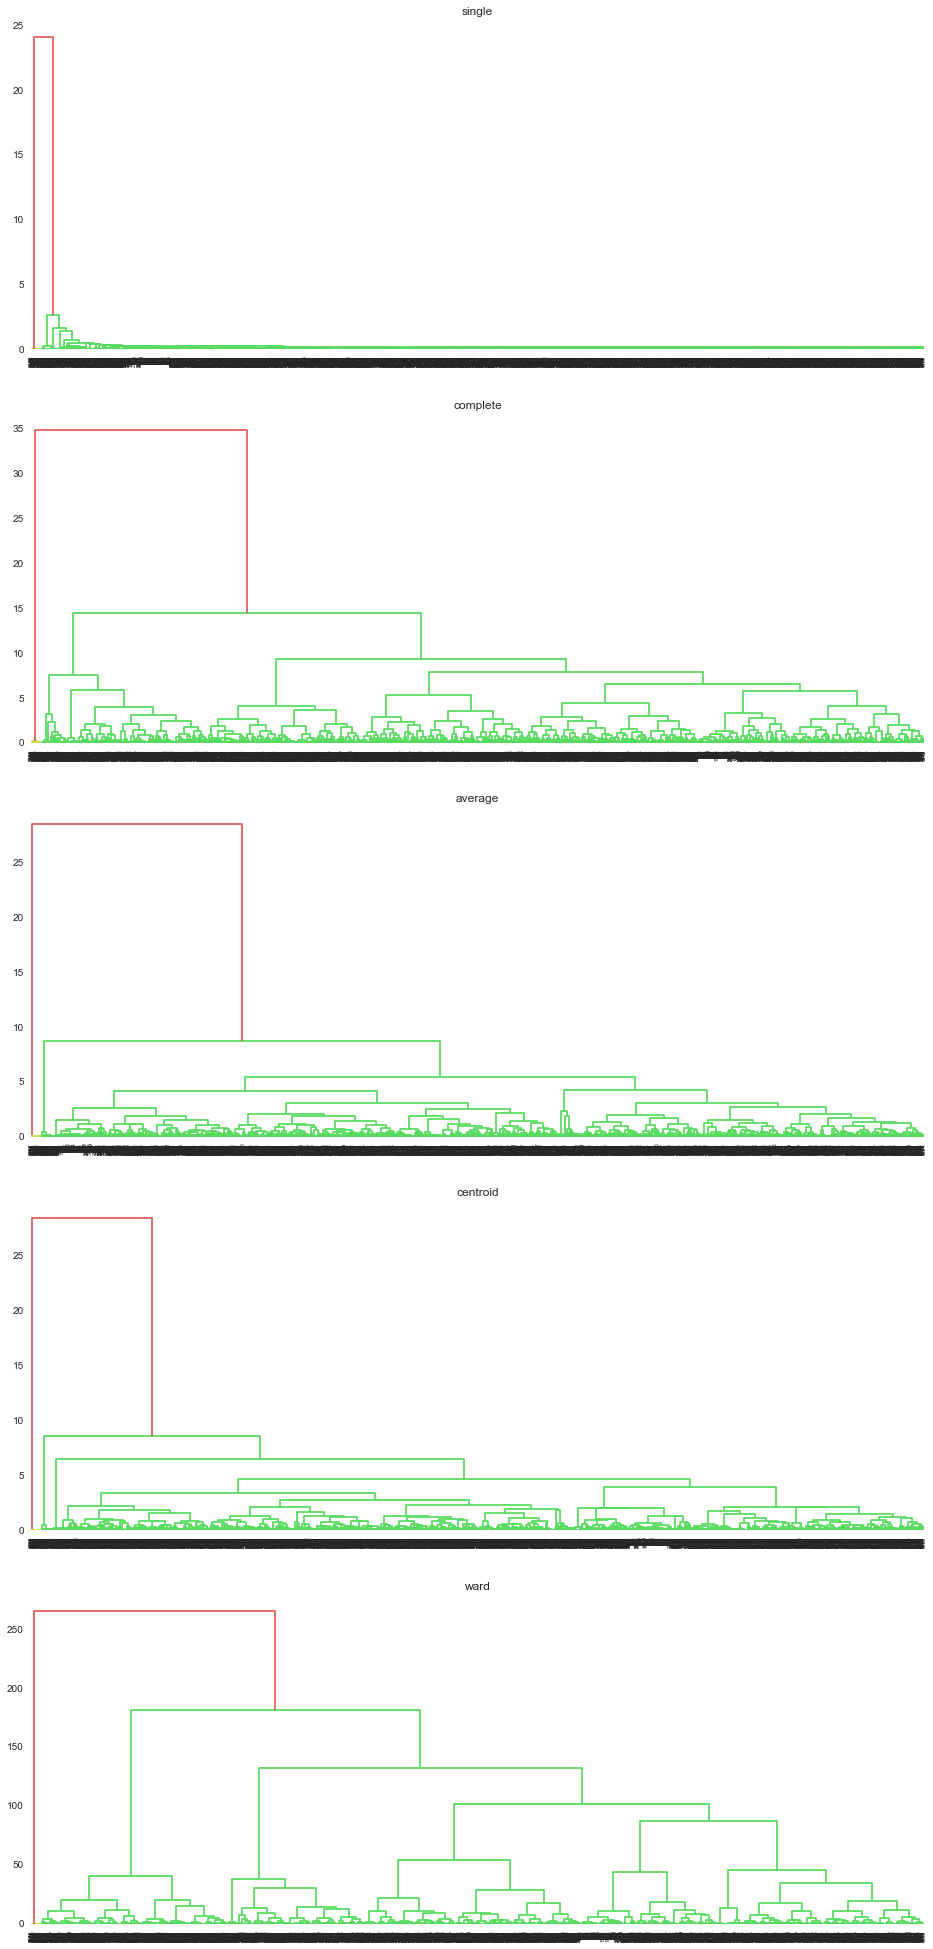

In [4]:
linkage_list = ['single', 'complete', 'average', 'centroid', 'ward']
fig, axes = plt.subplots(nrows=len(linkage_list), ncols=1, figsize=(16, 35))
for i, link in enumerate(linkage_list):
    print(f"generating dendrogram...: '{link}'")
    hierarchical_single = linkage(df_review_umap, method=link)
    dn = dendrogram(hierarchical_single, ax=axes[i])
    axes[i].title.set_text(link)

plt.show()

클러스터 개수 선정

      Date                                             Review  Star  Like  \
0  2022-09  진짜 자막뒤 검정화면 없애 줘요 정말 너무 불편해요 이게뭔가요 하나같이 다 업데이트...     1     0   
1  2022-09           갤럭시 폴드4 에서 한국드라마 한글자막 끄기 없어서 강제로 자막 봐야됨.     1     0   
2  2022-09                                    참좋아요. 모든게. 잘보고.     5     0   
3  2022-09  노트7FE에서 잘 봤는데 갑자기 오늘 기기에 호환되지 않습니다 라고 문구가 뜨면서 ...     1     0   
4  2022-09                          자막 진짜 언제 고치냐? 아직도 검정배경이냐.     1     3   

                 Version  Cluster  
0   8.40.0 build 4 50271        8  
1  8.39.1 build 12 50268       11  
2   8.40.0 build 4 50271        9  
3  8.35.0 build 19 50257        4  
4   8.40.0 build 4 50271        8  


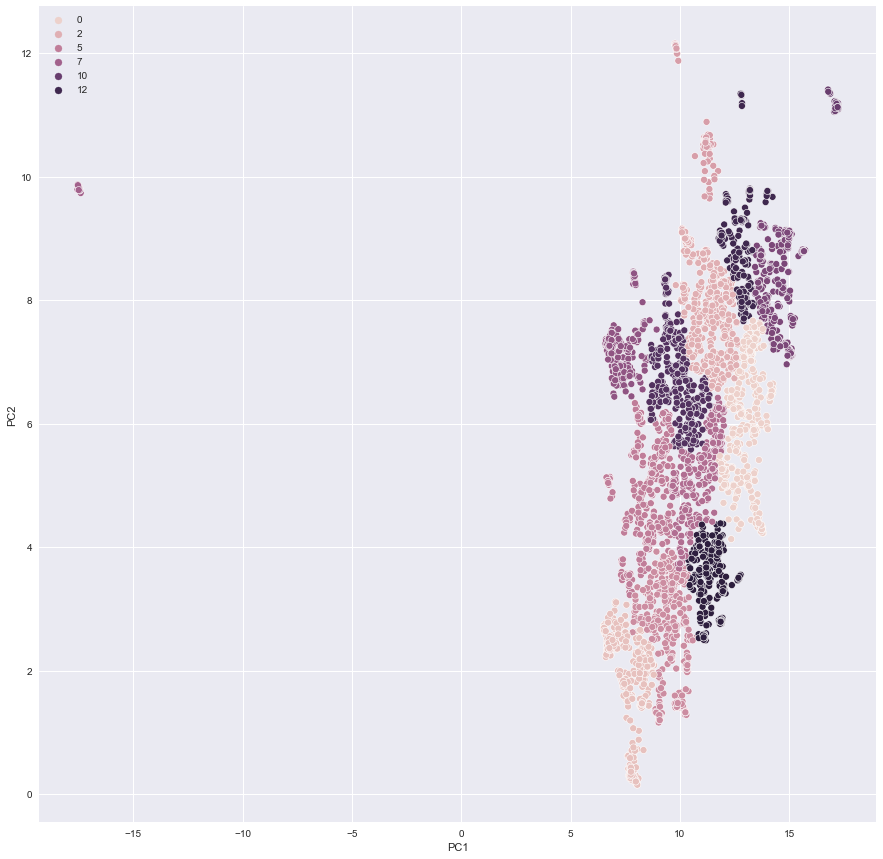

In [9]:
number_of_cluster = int(input("number of clusters :"))

agg_clustering = AgglomerativeClustering(n_clusters=number_of_cluster, linkage='ward')
labels = agg_clustering.fit_predict(df_review_umap)
plt.figure(figsize=(15, 15))
sns.scatterplot(x='PC1', y='PC2', data=df_review_umap, hue=labels)

df_cluster_label = pd.DataFrame(labels, columns = ['Label'],index = df_review_source.index)
clusters = [df_review_source[df_cluster_label['Label']==cluster_no] for cluster_no in range(0,number_of_cluster)]

df_review_with_cluster_label = df_review_source.copy(deep = True)
df_review_with_cluster_label['Cluster'] = df_cluster_label['Label']
print(df_review_with_cluster_label.head())

df_review_with_cluster_label.to_csv(target_file_format_new.format('P5_1',"",".csv"), encoding='utf-8-sig', header=False, index=False, quoting=csv.QUOTE_ALL)

del df_review_with_cluster_label

In [ ]:
print(clusters[2].Star)

LDA 분석

In [10]:
from gensim.corpora.dictionary import Dictionary

no_cluster = 0
number_of_topics = {}
corpus = None
dictionary = None
model_lda = None

# 1. LDA용 사전 만들기

# 명사만 넣기
pass_tags = ['NNG']
stop_words = ['며칠/NNG',"동안/NNG",'자체/NNG',"기가/NNG","가요/NNG","계속/NNG","이번/NNG","요즘/NNG","정도/NNG","진격/NNG","중인/NNG","짱구/NNG","무엇/NNG","한번/NNG","경우/NNG","제가/NNG","내가/NNG","주고/NNG","완전/NNG","이후/NNG","가기/NNG","이상/NNG","지가/NNG","어제/NNG","지금/NNG","하세/NNG","있음/NNG"]

print(f"stop words : {stop_words}")

#analyzer = CustomizedKkma(Kkma(), post_process_dict, post_processor_pos,stop_words,pass_words, pass_tags, join = False, filtering = True)
if is_mac:
    analyzer = CustomizedKkma(fake_Kkma(source_file_format.format("P4_2"), df_review_source), post_process_dict, post_processor_pos,stop_words,pass_words, pass_tags, join = False, filtering = True)
else:
    analyzer = CustomizedKkma(Kkma(), post_process_dict, post_processor_pos,stop_words,pass_words, pass_tags, join = False, filtering = True)

def tokenizer_for_LDA(doc):
    return analyzer.tokenizer(doc)

def get_corpus_dictionary_for_LDA(n_cluster, no_keep=2000, no_below_frequency=10, no_above_probability = 0.5):
    texts = [tokenizer_for_LDA(r) for r in clusters[n_cluster].Review]
    # 사전 생성 (1): 토큰으로부터 사전 생성
    dictionary = Dictionary(texts)
    print(f" 1) 단어 개수 : {len(dictionary)}")

    # 사전 생성 (2) : 필터링
    dictionary.filter_extremes(keep_n=no_keep, no_below=no_below_frequency, no_above = no_above_probability)
    print(f" 2) 사전 필터링 후 단어 개수 : {len(dictionary)}")

# 카운터 벡터로 변환
    corpus = [dictionary.doc2bow(t) for t in texts]
    print(f" 3) 문서 수 : {len(corpus)}")
    return (corpus, dictionary)
    


    

stop words : ['며칠/NNG', '동안/NNG', '자체/NNG', '기가/NNG', '가요/NNG', '계속/NNG', '이번/NNG', '요즘/NNG', '정도/NNG', '진격/NNG', '중인/NNG', '짱구/NNG', '무엇/NNG', '한번/NNG', '경우/NNG', '제가/NNG', '내가/NNG', '주고/NNG', '완전/NNG', '이후/NNG', '가기/NNG', '이상/NNG', '지가/NNG', '어제/NNG', '지금/NNG', '하세/NNG', '있음/NNG']


In [11]:
class MinMaxNormalizer:
    def __init__(self, min_v, max_v, scale):
        self.__min = min_v
        self.__max = max_v
        self.__multiplier = scale / (self.__max - self.__min)
    
    def norm(self,v):
        return (v-self.__min)*self.__multiplier

class OpportunityCriteria:
    def __init__(self, importance_mean, importance_min, importance_max, satisfactory_mean, satisfactory_median=3, satisfactory_max=5 ):
        self.__importance_scale = MinMaxNormalizer(importance_min, importance_max, 10)
        self.__satisfactory_scale = MinMaxNormalizer(satisfactory_median, satisfactory_max, 10)
        self.__importance_m = self.__importance_scale.norm(importance_mean)
        self.__satisfactory_m = self.__satisfactory_scale.norm(satisfactory_mean)
        self.__upper_coeff = (10.0 - self.__satisfactory_m )*0.1
        self.__lower_coeff = 20.0 / (10.0 - self.__importance_m )
    
    def __upper_line(self,i,s):
        s_upper = self.__upper_coeff*self.__importance_scale.norm(i) + self.__satisfactory_m
        return self.__satisfactory_scale.norm(s)>s_upper
    
    def __lower_line(self,i,s):
        s_lower = self.__lower_coeff*(self.__importance_scale.norm(i)-10.0) + 10.0
        return self.__satisfactory_scale.norm(s)>s_lower

    def get_opportunity(self, importance, satisfactory):

        overall_opportunity = [["A.Exiting Area","B.Experiencing Area","C.Competitive Area"],["D.Forgiven Area","E. Dangling Area","F.At-Risk Area"]]
        opportunity = overall_opportunity[0]
        if self.__satisfactory_scale.norm(satisfactory) < 0 :
            opportunity = overall_opportunity[1]

        opportunity_index = 2
        if self.__upper_line(importance, satisfactory):
            opportunity_index = 0
        elif self.__lower_line(importance, satisfactory):
            opportunity_index = 1
        
        return opportunity[opportunity_index]

def get_satisfactory_matrix(lda_model, _corpus, _dictionary, sentimental_points):
    sentimental_point_list_per_word = {}
    for index, doc in enumerate(_corpus):
        for (word,count) in doc:
            if word in sentimental_point_list_per_word:
                sentimental_point_list_per_word[word].append(sentimental_points[index])
            else:
                sentimental_point_list_per_word.update({word:[sentimental_points[index]]})

    s = np.zeros(len(_dictionary))

    sentimental_point_per_word = {}
    for key in sentimental_point_list_per_word:
        s[key] = np.mean(sentimental_point_list_per_word[key])
    topic_words_matrix = pd.DataFrame(lda_model.get_topics())
    return topic_words_matrix.dot(pd.Series(s))

def get_importance_matrix(lda_model, _corpus, n_topic):

    topic_weight_sum = np.zeros(n_topic)
    for doc in _corpus:
        for (topic, weight) in lda_model.get_document_topics(doc):
            topic_weight_sum[topic] = topic_weight_sum[topic] + weight

    return pd.Series(topic_weight_sum)

def LDA_analyze(no_cluster, ending_number_of_topics, coherence_perplexity = True):

    n_pass = 10
    n_iteration = 100
    n_topics = 0
    
    def show_coherence_perplexity(corpus, dictionary, begining_number_of_topics = 2, ending_number_of_topics = 30):
        iter_num = []
        per_value = []
        coh_value = []
        
        for i in range(begining_number_of_topics, ending_number_of_topics):
            model = LdaModel(corpus=corpus, id2word = dictionary, chunksize=1000, num_topics=i, passes = n_pass, iterations = n_iteration)
            iter_num.append(i)
            pv = model.log_perplexity(corpus)
            per_value.append(pv)
            
            cm = CoherenceModel(model=model, corpus=corpus,coherence='u_mass')
            cv = cm.get_coherence()
            coh_value.append(cv)
            print(f"num_topics:{i}, perplexity:{pv:0.3f} , coherence:{cv:0.3f}")
            
        plt.plot(iter_num, per_value, 'g-')
        plt.xlabel("num topics")
        plt.ylabel("perplexity")
        plt.show()

        plt.plot(iter_num, coh_value, 'r-')
        plt.xlabel("num topics")
        plt.ylabel("coherence")
        plt.show()

    if coherence_perplexity:
        show_coherence_perplexity(corpus, dictionary,begining_number_of_topics=2, ending_number_of_topics=ending_number_of_topics)
    
    if no_cluster not in number_of_topics:
        n_topics = int(input("number of topics : "))
        number_of_topics.update({no_cluster: n_topics})
    else:
        n_topics = number_of_topics[no_cluster]
    
    return  LdaModel(corpus=corpus, id2word=dictionary, passes = n_pass, num_topics=n_topics, iterations = n_iteration)

def store_LDA_result(no_cluster):

    n_topics = number_of_topics[no_cluster]
    doc_topic_matrix = pd.DataFrame()

    for i, doc in enumerate(corpus):
        topic_row = np.zeros(n_topics)

        for (t,w) in model_lda.get_document_topics(doc):
            topic_row[t] = w
        doc_topic_matrix = pd.concat([doc_topic_matrix, pd.DataFrame(topic_row, columns=[f'D{i}'])], axis = 1)
    doc_topic_matrix = doc_topic_matrix.transpose()
    doc_topic_matrix = doc_topic_matrix.reset_index(drop=True)
    review = clusters[no_cluster].Review.copy()
    senti = clusters[no_cluster].Star.copy()
    review = review.reset_index(drop=True)
    senti = senti.reset_index(drop = True)

    doc_topic_matrix['review'] = review
    
    temp_columns = [ f'T{j}' for j in range(0,n_topics )]
    temp_columns.append("Review")
    doc_topic_matrix.columns = temp_columns
    doc_topic_matrix.to_csv(target_file_format_new.format("P5_3",f"C{no_cluster}_LDA",".csv"), encoding='utf-8-sig', header=True, index=False, quoting=csv.QUOTE_ALL)

    satisfactory = get_satisfactory_matrix(model_lda, corpus, dictionary,senti)
    importance = get_importance_matrix(model_lda,corpus,n_topics)
    importance_mean = importance.mean()
    importance_min = importance.min()
    importance_max = importance.max()
    satisfactory_mean = satisfactory.mean()

    oc = OpportunityCriteria(importance_mean, importance_min, importance_max, satisfactory_mean)

    opportunity =[ oc.get_opportunity(im,satisfactory[idx]) for idx, im in enumerate(importance) ]
    opportunity_map = pd.DataFrame()
    opportunity_map = pd.concat([opportunity_map, importance,satisfactory, pd.Series(opportunity) ], axis=1)
    opportunity_map.columns = ['중요도(Importance)','만족도(Satisfactory)',"기회영역(Opportunity)"]
    opportunity_map.to_csv(target_file_format_new.format("P5_4",f"C{no_cluster}_Opp",".csv"), encoding='utf-8-sig', header=True, index=True, quoting=csv.QUOTE_ALL)





LDA 사전 / 코퍼스 생성 , 혼잡도_응집도 평가

노트/NNG|7/NR|FE/OL|에서/JKM|잘/MAG|보/VV|았/EPT|는데/ECD|갑자기/MAG|오늘/NNG|기기/NNG|에/JKM|호환/NNG|되/XSV|지/ECD|안/MAG|습니다/EFN|라고/JKQ|문구/NNG|가/JKS|뜨/VV|면서/ECE|아무것/NNG|도/JX|안/MAG|되/VV|네요/EFN|./SF|저/NP|의/JKG|거하/VV|었/EPT|다가/ECD|재/XPN|설치/NNG|하/XSV|려고/ECD|하/VX|니/ECD|설치/NNG|도/JX|안/MAG|되/VV|네요/EFN|./SF|방법/NNG|이/JKS|없/VA|는/ETD|것/NNB|이/VCP|ㄴ가요/EFQ|?/SF
Step1 ['노트/NNG', '7/NR', 'FE/OL', '에서/JKM', '잘/MAG', '보/VV', '았/EPT', '는데/ECD', '갑자기/MAG', '오늘/NNG', '기기/NNG', '에/JKM', '호환/NNG', '되/XSV', '지/ECD', '안/MAG', '습니다/EFN', '라고/JKQ', '문구/NNG', '가/JKS', '뜨/VV', '면서/ECE', '아무것/NNG', '도/JX', '안/MAG', '되/VV', '네요/EFN', './SF', '저/NP', '의/JKG', '거하/VV', '었/EPT', '다가/ECD', '재/XPN', '설치/NNG', '하/XSV', '려고/ECD', '하/VX', '니/ECD', '설치/NNG', '도/JX', '안/MAG', '되/VV', '네요/EFN', './SF', '방법/NNG', '이/JKS', '없/VA', '는/ETD', '것/NNB', '이/VCP', 'ㄴ가요/EFQ', '?/SF']
tokenize
Step2 노트/NNG|7/NR|FE/OL|에서/JKM|잘/MAG|보/VV|았/EPT|는데/ECD|갑자기/MAG|오늘/NNG|기기/NNG|에/JKM|호환/NNG|되/XSV|지/ECD|안/MAG|습니다/EFN|라고/JKQ|문구/NNG|가/JKS|뜨/VV|면서/ECE|아무것/NNG|도/JX|안/MAG|

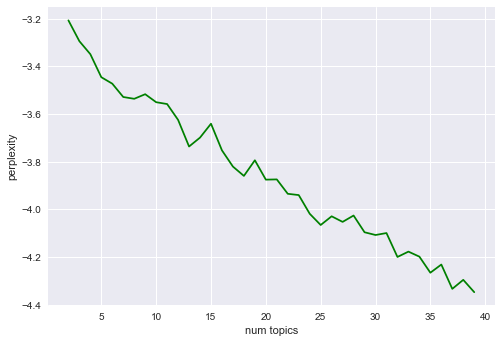

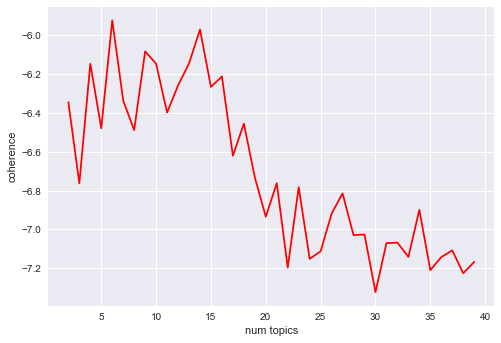

/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: 

In [24]:
no_cluster = 4
number_of_topics = {}
corpus, dictionary = get_corpus_dictionary_for_LDA(no_cluster)
model_lda = LDA_analyze(no_cluster,ending_number_of_topics=40, coherence_perplexity=True)  
vis = gensimvis.prepare(model_lda, corpus, dictionary,sort_topics=False)
pyLDAvis.save_html(vis, target_file_format_new.format("P5_2",f"C{no_cluster}",".html"))
store_LDA_result(no_cluster)

In [22]:
# 사용자로부터 Topic 숫자 입력없이 LDA 분석. coherence_perplexity 분석은 안한다.(시간이 오래걸리니까, 이전 분석결과 활용)


no_topics = 13
number_of_topics = {no_cluster:no_topics}
model_lda = LDA_analyze(no_cluster,ending_number_of_topics=40, coherence_perplexity=False)  
vis = gensimvis.prepare(model_lda, corpus, dictionary,sort_topics=False)
pyLDAvis.save_html(vis, target_file_format_new.format("P5_2",f"C{no_cluster}",".html"))
store_LDA_result(no_cluster)

/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: 

In [ ]:

number_of_topics = {0:10,1:10,2:10,3:10,4:10,5:10}
for no_cluster in range(0,6):
    corpus, dictionary = get_corpus_dictionary_for_LDA(no_cluster)
    model_lda = LDA_analyze(no_cluster,ending_number_of_topics=40, coherence_perplexity=False)  
    vis = gensimvis.prepare(model_lda, corpus, dictionary)
    pyLDAvis.save_html(vis, target_file_format_new.format("P5_2",f"C{no_cluster}",".html"))
    store_LDA_result(no_cluster)